In [39]:
import pretty_midi as pm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import CONSTANTS as c

In [40]:
def read_midi_stream(file_path):
    midi_stream = pm.PrettyMIDI(file_path)
    return midi_stream

In [41]:
def preprocess_df(df_original):
    df = df_original.copy()

    sequence_start_time = df['time'].iloc[0]
    if sequence_start_time != 0:
        df['time'] = df['time'] - sequence_start_time

    return df

In [42]:
def convert_to_beat_dataframe(df):
    # Determine the total duration of the piece
    total_duration = df['time'].max()
    spb = 60 / df['tempo'].iloc[0]  # Seconds per beat
    sixteenth_duration = spb / 16  # Duration of a 1/16th note

    # Ensure total_duration and sixteenth_duration are scalar values
    total_duration = total_duration.item() if hasattr(total_duration, 'item') else total_duration
    sixteenth_duration = sixteenth_duration.item() if hasattr(sixteenth_duration, 'item') else sixteenth_duration

    # Create a list of beat numbers corresponding to each 1/16th note
    num_beats = int(total_duration / spb)
    beat_numbers = list(range(num_beats + 1))

    # Initialize dictionary to store instrument play times
    instrument_play_times = {instrument: [0] * len(beat_numbers) for instrument in df['name'].unique()}

    # Iterate through each instrument entry and mark 1 for the corresponding beats
    for _, row in df.iterrows():
        beat_number = int(row['time'] / spb)
        instrument_play_times[row['name']][beat_number] = 1

    # Create a new DataFrame
    beat_df = pd.DataFrame(instrument_play_times, index=beat_numbers)

    return beat_df

In [43]:
def process_session(file_path, file_info):
    pitches = []
    start_times = []

    midi_stream = read_midi_stream(file_path)

    for instrument in midi_stream.instruments:
        for note in instrument.notes:
            pitches.append(note.pitch)
            start_times.append(note.start)

    df = pd.DataFrame(
        {
            'pitch': pitches,
            'time': start_times
        }
    )

    df['genre'] = file_info[1]
    df['tempo'] = int(file_info[2])

    df = df.join(c.pitch_name_map.set_index('Pitch')['Paper Mapping'].rename('name'), on='pitch')

    df = preprocess_df(df)
    df = convert_to_beat_dataframe(df)

    wanted_columns = ['Bass (36)', 'Closed Hi-Hat (42)', 'Snare (38)', 'Open Hi-Hat (46)']

    columns_to_keep = [
        c for c in df.columns if c in wanted_columns
    ]

    df = df[columns_to_keep]

    return df

In [44]:
def plot_instrument_playtimes(beat_df):
    fig, ax = plt.subplots(figsize=(10,6))

    # Plot instrument playtimes
    for instrument in beat_df.columns:
        ax.scatter(beat_df.index, [instrument] * len(beat_df), c=beat_df[instrument], cmap='Blues', marker='o', label=instrument)
    
    ax.set_yticks(range(len(beat_df.columns)))
    ax.set_yticklabels(beat_df.columns)
    ax.set_xlabel('Beat Number')
    ax.set_ylabel('Instrument')
    ax.set_title('Instrument Playtimes')
    ax.grid(True)
    ax.legend()

    return fig

In [45]:
genre_counter = {}

In [46]:
sequence_id = 0

drummers = [d for d in os.listdir(c.DATASET_PATH) if 'drummer' in d]
for drummer in drummers:
    drummer_path = os.path.join(c.DATASET_PATH, drummer)
    sessions = [s for s in os.listdir(drummer_path) if 'session' in s and 'eval' not in s]
    for session in sessions:
        session_path = os.path.join(drummer_path, session)
        midi_files = [f for f in os.listdir(session_path) if 'beat' in f and '4-4' in f]
        for file in midi_files:
            file_info = file.split("_")
            file_path = os.path.join(session_path, file)

            file_name = file_info[1]

            if 'funk' in file_name:
                df = process_session(file_path, file_info)
                df.to_pickle(f'processed/sequence_{sequence_id}')
                sequence_id += 1

In [47]:
df_test = pd.read_pickle('processed/sequence_0')
df_test

,Bass (36),Closed Hi-Hat (42),Snare (38),Open Hi-Hat (46)
0,1,1,0,0
1,1,1,1,0
2,1,1,1,0
3,1,1,0,0
4,1,1,1,0
...,...,...,...,...
251,1,0,1,1
252,1,0,1,0
253,1,0,1,0
254,1,0,1,0


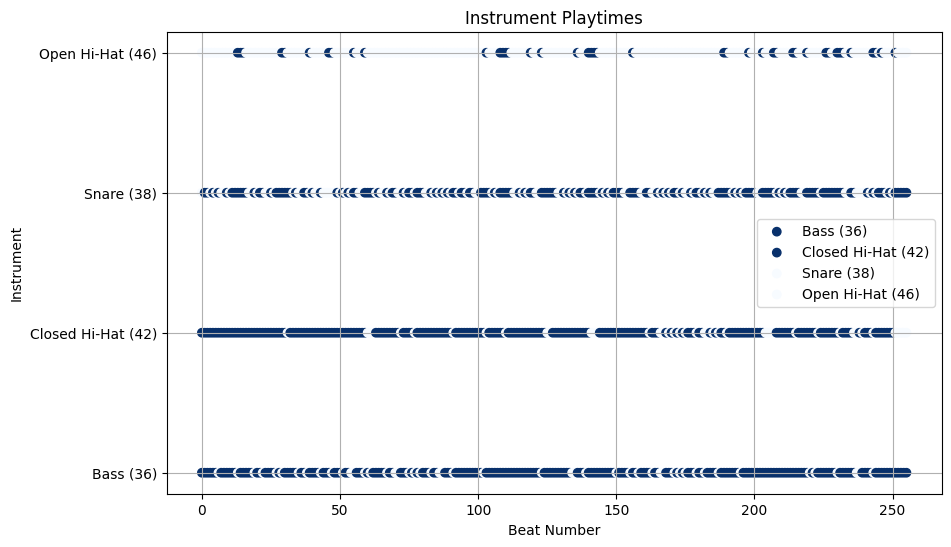

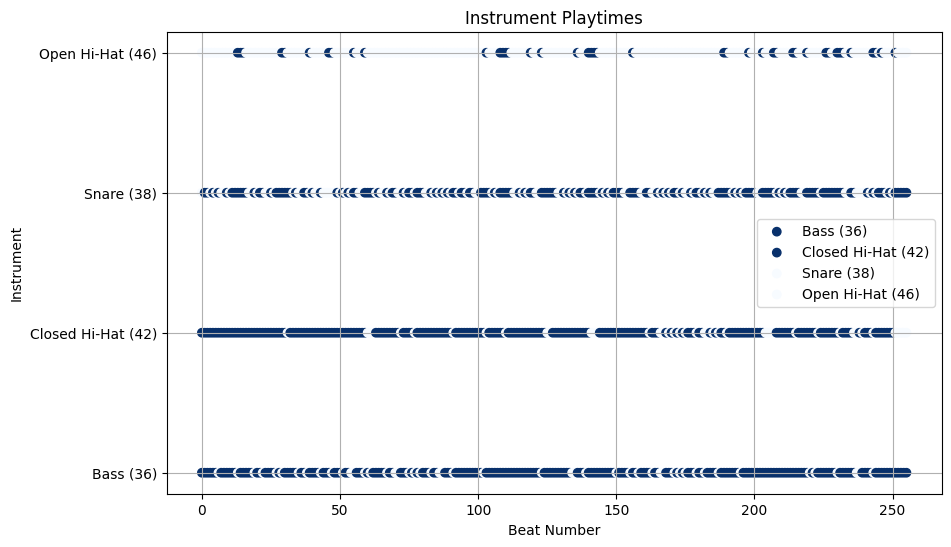

In [48]:
plot_instrument_playtimes(df_test)

In [49]:
genre_counter

{}